In [2]:
# Core
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from itertools import combinations
import math
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import multivariate_normal
import time
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
from termcolor import colored
import warnings
warnings.filterwarnings("ignore")

# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# UMAP
import umap
# import umap.plot

In [3]:
class GMM:
    def __init__(self, k, max_iter=100, random_state = 0):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def initialise(self, X):
        self.shape = X.shape
        self.n, self.d = self.shape

        self.pi = np.full(shape=self.k, fill_value=1/self.k)
        self.responsibilities = np.full(shape=self.shape, fill_value=1/self.k)

        np.random.seed(self.random_state)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def E_step(self, X):
        # E-Step: update the responsibilities by holding mu and sigma constant
        self.responsibilities = self.predict_proba(X)

    def M_step(self, X):
        # M-Step: update pi, mu and sigma by holding responsibilities constant
        self.pi = self.responsibilities.mean(axis=0)
        for j in range(self.k):
            r_column = self.responsibilities[:,j]
            total_responsibility = r_column.sum()
            self.mu[j] = (X * r_column[:, np.newaxis]).sum(axis=0)/total_responsibility
            self.sigma[j] = np.cov(X.T, aweights=(r_column/total_responsibility).flatten(), bias=True)

    def fit(self, X):
        self.initialise(X)

        for iteration in range(self.max_iter):
            self.E_step(X)
            self.M_step(X)

    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for j in range(self.k):
            distribution = multivariate_normal(mean=self.mu[j], cov=self.sigma[j])
            likelihood[:,j] = distribution.pdf(X)

        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        responsibilities = numerator / denominator
        return responsibilities

    def predict(self, X):
        responsibilities = self.predict_proba(X)
        return np.argmax(responsibilities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        predictions = self.predict(X)
        return predictions

In [5]:
from sklearn.datasets import load_iris

# Declare GaussianMixture Model
X = load_iris().data
gmm = GMM(k=7, max_iter=100)
preds = gmm.fit_predict(X)

Text(0.5, 1.0, 'Predicted clusters')

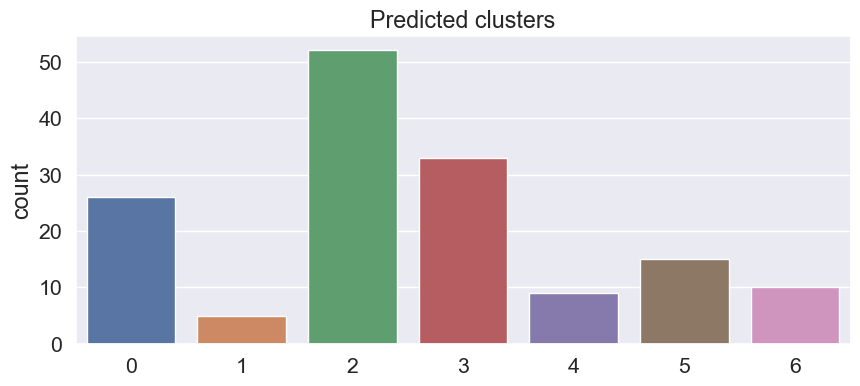

In [6]:
# Countplot
plt.figure(figsize=(10,4))
sns.countplot(x=preds)
plt.title('Predicted clusters')